Using python (scipy.signal) to extract peaks

Then saving peak information as .csv files to open in R for statistical analysis

In [1]:
import scipy
import os
import numpy as np
import pandas as pd
import skimage as sk
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
# set plot defaults
import matplotlib as mpl
import math

Read in files as a dictionary that contains the session as keys and arrays of fluorescence as values

In [2]:
dir_data = r'C:\Users\stuberadmin\Documents\2p_analysis_20220217\Day7_analysis\Evoked_activity_analysis\Average_PSTH'
save_dir = r'C:\Users\stuberadmin\Documents\2p_analysis_20220217\Day7_analysis\Evoked_activity_analysis\output'
dir_files = os.listdir(dir_data)

Importing everything as two massive dictionaries: one for sucrose, and one for airpuff

In [3]:
list_conditions = ['saline_Day0','morphine_Day0','saline_Day7_sal','morphine_Day7_sal','saline_Day7_nal','morphine_Day7_nal']

In [4]:
os.chdir(dir_data)

puff = pd.DataFrame()
suc = pd.DataFrame()

array_dict_suc = dict()
array_dict_puff = dict()

for string in list_conditions:
    for file in dir_files:
        if string in file:
            if 'puff' in file:
                temp1 = pd.read_excel(file).drop('Unnamed: 0', axis=1)#.iloc[:,0:57]
                puff = pd.concat([puff, temp1])
            elif 'suc' in file:
                temp2 = pd.read_excel(file).drop('Unnamed: 0', axis=1)#.iloc[:,0:57]
                suc = pd.concat([suc, temp2])
    array_dict_suc[string] = suc
    array_dict_puff[string] = puff
    puff = pd.DataFrame()
    suc = pd.DataFrame()  

Zscoring the traces within each session

In [5]:
from scipy import stats

In [6]:
Zscore_df = pd.DataFrame()
puff_zscore = dict()

for key in array_dict_puff:
    zscored = stats.zscore(array_dict_puff[key].iloc[:,0:75], axis=1)
    Zscore_df = pd.concat([Zscore_df, zscored])
    puff_zscore[key] = Zscore_df
    Zscore_df = pd.DataFrame()
    
Zscore_df = pd.DataFrame()
suc_zscore = dict()

for key in array_dict_suc:
    zscored = stats.zscore(array_dict_suc[key].iloc[:,0:75], axis=1)
    Zscore_df = pd.concat([Zscore_df, zscored])
    suc_zscore[key] = Zscore_df
    Zscore_df = pd.DataFrame()

Or dF/F

In [7]:
dF_df = pd.DataFrame()
puff_dF = dict()

for key in array_dict_puff:
    for index, row in array_dict_puff[key].iterrows():
        df_list = list()
        for frame in row:
            #dF/F calculation using the timestamps prior to airpuff/suc delivery
            df = (frame - np.nanmean(row[0:19]))/np.nanmean(row[0:19])
            df_list.append(df)
        dF_df = pd.concat([dF_df, pd.DataFrame(df_list[0:75])], axis=1)
        df_list = list()
    puff_dF[key] = dF_df.transpose()
    dF_df = pd.DataFrame()
    
dF_df = pd.DataFrame()
suc_dF = dict()

for key in array_dict_puff:
    for index, row in array_dict_suc[key].iterrows():
        df_list = list()
        for frame in row:
            #dF/F calculation using the timestamps prior to airpuff/suc delivery
            df = (frame - np.mean(row[0:19]))/np.mean(row[0:19])
            df_list.append(df)
        dF_df = pd.concat([dF_df, pd.DataFrame(df_list[0:75])], axis=1)
        df_list = list()
    suc_dF[key] = dF_df.transpose()
    dF_df = pd.DataFrame()

### Plotting traces

Airpuff trials

In [8]:
time = np.arange(0, 57)

In [85]:
nal = puff_dF['saline_Day0'].iloc[:,0:57].mean(axis=0)
nal_sem = puff_dF['saline_Day0'].iloc[:,0:57].sem(axis=0)
mor = puff_dF['morphine_Day0'].iloc[:,0:57].mean(axis=0)
mor_sem = puff_dF['morphine_Day0'].iloc[:,0:57].sem(axis=0)

In [86]:
len(time)

57

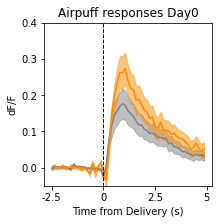

In [87]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Airpuff responses Day0")
sns.lineplot(x=time, y=nal, color='gray',label="naline")
plt.fill_between(time, nal-nal_sem,  nal + nal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

ax.set_ylim(-.05, 0.4)
ax.get_legend().remove()
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='dF/F')
os.chdir(save_dir)
fig.savefig('Day0_airpuff_mean_dF.pdf', format='pdF', dpi=300)
fig.savefig('Day0_airpuff_mean_dF.png', format='png', dpi=300)

In [92]:
sal = puff_dF['saline_Day7_sal'].iloc[:,0:57].mean(axis=0)
sal_sem = puff_dF['saline_Day7_sal'].iloc[:,0:57].sem(axis=0)
mor = puff_dF['morphine_Day7_sal'].iloc[:,0:57].mean(axis=0)
mor_sem = puff_dF['morphine_Day7_sal'].iloc[:,0:57].sem(axis=0)

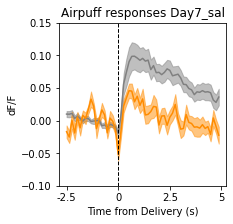

In [95]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Airpuff responses Day7_sal")
sns.lineplot(x=time, y=sal, color='gray',label="saline")
plt.fill_between(time, sal-sal_sem,  sal + sal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

ax.set_ylim(-.1, 0.15)
ax.get_legend().remove()
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='dF/F')
os.chdir(save_dir)
fig.savefig('Day7_sal_Airpuff_mean_dF.pdF', format='pdF', dpi=300)
fig.savefig('Day7_sal_Airpuff_mean_dF.png', format='png', dpi=300)

In [96]:
sal = puff_dF['saline_Day7_nal'].iloc[:,0:57].mean(axis=0)
sal_sem = puff_dF['saline_Day7_nal'].iloc[:,0:57].sem(axis=0)
mor = puff_dF['morphine_Day7_nal'].iloc[:,0:57].mean(axis=0)
mor_sem = puff_dF['morphine_Day7_nal'].iloc[:,0:57].sem(axis=0)

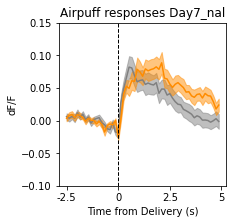

In [97]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Airpuff responses Day7_nal")
sns.lineplot(x=time, y=sal, color='gray',label="saline")
plt.fill_between(time, sal-sal_sem,  sal + sal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

ax.set_ylim(-.1, 0.15)
ax.get_legend().remove()
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='dF/F')
os.chdir(save_dir)
fig.savefig('Day7_nal_Airpuff_mean_dF.pdF', format='pdF', dpi=300)
fig.savefig('Day7_nal_Airpuff_mean_dF.png', format='png', dpi=300)

Sucrose trials

In [78]:
time = np.arange(0, 57)

In [79]:
sal = suc_zscore['saline_Day0'].iloc[:,0:57].mean(axis=0)
sal_sem = suc_zscore['saline_Day0'].iloc[:,0:57].sem(axis=0)
mor = suc_zscore['morphine_Day0'].iloc[:,0:57].mean(axis=0)
mor_sem = suc_zscore['morphine_Day0'].iloc[:,0:57].sem(axis=0)

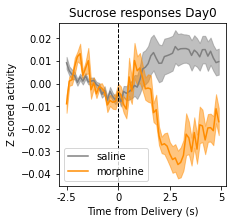

In [80]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Sucrose responses Day0")
sns.lineplot(x=time, y=sal, color='gray',label="saline")
plt.fill_between(time, sal-sal_sem,  sal + sal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

#ax.set_ylim(-1,1)
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='Z scored activity')
os.chdir(save_dir)
#fig.savefig('Day0_sucrose_mean_zscore.pzscore', format='pzscore', dpi=300)
#fig.savefig('Day0_sucrose_mean_zscore.png', format='png', dpi=300)

In [134]:
sal = suc_dF['saline_Day7_sal'].iloc[:,0:57].mean(axis=0)
sal_sem = suc_dF['saline_Day7_sal'].iloc[:,0:57].sem(axis=0)
mor = suc_dF['morphine_Day7_sal'].iloc[:,0:57].mean(axis=0)
mor_sem = suc_dF['morphine_Day7_sal'].iloc[:,0:57].sem(axis=0)

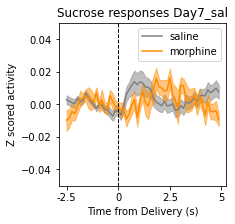

In [135]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Sucrose responses Day7_sal")
sns.lineplot(x=time, y=sal, color='gray',label="saline")
plt.fill_between(time, sal-sal_sem,  sal + sal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

ax.set_ylim(-.05,0.05)
#ax.set_ylim(-1,1)
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='Z scored activity')
os.chdir(save_dir)
fig.savefig('Day7_sal_sucrose_mean_dF.pdF', format='pdF', dpi=300)
fig.savefig('Day7_sal_sucrose_mean_dF.png', format='png', dpi=300)

In [136]:
sal = suc_dF['saline_Day7_nal'].iloc[:,0:57].mean(axis=0)
sal_sem = suc_dF['saline_Day7_nal'].iloc[:,0:57].sem(axis=0)
mor = suc_dF['morphine_Day7_nal'].iloc[:,0:57].mean(axis=0)
mor_sem = suc_dF['morphine_Day7_nal'].iloc[:,0:57].sem(axis=0)

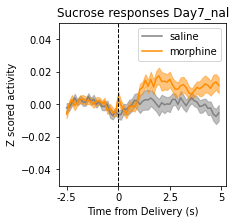

In [137]:
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
plt.title("Sucrose responses Day7_nal")
sns.lineplot(x=time, y=sal, color='gray',label="saline")
plt.fill_between(time, sal-sal_sem,  sal + sal_sem, color='gray', alpha=0.5)
sns.lineplot(x=time, y=mor, label="morphine", color='darkorange')
plt.fill_between(time, mor-mor_sem,  mor + mor_sem, alpha=0.5, color='darkorange')

ax.set_ylim(-.05,0.05)
#ax.set_ylim(-1,1)
ax.set_xticks([0,19,38,57])
ax.set_xticklabels(['-2.5','0','2.5','5'])
ax.axvline(19, lw='1', color='k', linestyle='--')
ax.set(xlabel='Time from Delivery (s)', ylabel='Z scored activity')
os.chdir(save_dir)
fig.savefig('Day7_nal_sucrose_mean_dF.pdF', format='pdF', dpi=300)
fig.savefig('Day7_nal_sucrose_mean_dF.png', format='png', dpi=300)

### Evaluating peak features of all cells

In [43]:
Day0_df_sal = puff_dF['saline_Day0'].iloc[:,0:75]
Day7_sal_df_sal = puff_dF['saline_Day7_sal'].iloc[:,0:75]
Day7_nal_df_sal = puff_dF['saline_Day7_nal'].iloc[:,0:75]

In [44]:
Day0_df_mor = puff_dF['morphine_Day0'].iloc[:,0:75]
Day7_sal_df_mor = puff_dF['morphine_Day7_sal'].iloc[:,0:75]
Day7_nal_df_mor = puff_dF['morphine_Day7_nal'].iloc[:,0:75]

In [45]:
big_dict_sal = {'Day0': Day0_df_sal,
            'Day7_sal': Day7_sal_df_sal,
            'Day7_nal': Day7_nal_df_sal,
}

In [46]:
big_dict_mor = {'Day0': Day0_df_mor,
            'Day7_sal': Day7_sal_df_mor,
            'Day7_nal': Day7_nal_df_mor,
}

Calculating area under the curve

In [47]:
import numpy as np
from scipy.integrate import simpson
from numpy import trapz

In [54]:
auc_list = list()
auc_df = pd.DataFrame()

for key in big_dict_sal:
    for index, row in big_dict_sal[key].iterrows():
        t = row
        auc = trapz(row[20:77], dx=1)
        auc_list.append(auc)
    auc_df = pd.concat([auc_df, pd.DataFrame(auc_list)], axis=1)
    auc_list = list()
auc_df.columns = ['Day0','Day7_sal','Day7_nal']

In [55]:
auc_df.to_excel(save_dir + '/auc_puff_dF_responsive_sal.xlsx')

Finding position and value of the peak response

In [56]:
max_ix = pd.DataFrame()
max_ix_list = list()

max_response = pd.DataFrame()
max_response_list = list()

for key in big_dict_sal:
    for ix in range(len(big_dict_sal[key])):
        max = np.argmax(big_dict_sal[key].iloc[ix][19:57])
        max_ix_list.append(max+19)
        max_value = big_dict_sal[key].iloc[ix, max+19]
        max_response_list.append(max_value)
    max_ix = pd.concat([max_ix, pd.DataFrame(max_ix_list)], axis=1)
    max_response = pd.concat([max_response, pd.DataFrame(max_response_list)], axis=1)
    max_ix_list = list()
    max_response_list = list()
max_ix.columns = ['Day0','Day7_sal','Day7_nal']
max_response.columns = ['Day0','Day7_sal','Day7_nal']

In [57]:
max_ix.to_excel(save_dir + '/max_peak_ix_puff_dF_sal.xlsx')
max_response.to_excel(save_dir + '/max_peak_puff_dF_sal.xlsx')

In [58]:
#Finding the index of the max response, taking into account both positive and negative directions
max_ix = pd.DataFrame()
max_ix_list = list()

max_response = pd.DataFrame()
max_response_list = list()

for key in big_dict_sal:
    for ix in range(len(big_dict_sal[key])):
        max = np.argmax(abs(big_dict_sal[key].iloc[ix][19:75]))
        max_ix_list.append(max+19)
        max_value = big_dict_sal[key].iloc[ix, max+19]
        max_response_list.append(max_value)
    max_ix = pd.concat([max_ix, pd.DataFrame(max_ix_list)], axis=1)
    max_response = pd.concat([max_response, pd.DataFrame(max_response_list)], axis=1)
    max_ix_list = list()
    max_response_list = list()
max_ix.columns = ['Day0','Day7_sal','Day7_nal']
max_response.columns = ['Day0','Day7_sal','Day7_nal']

In [59]:
max_ix.to_excel(save_dir + '/max_peak_ix_puff_dF_sal.xlsx')
max_response.to_excel(save_dir + '/max_peak_puff_dF_sal.xlsx')

### Evaluating peak features of responsive cells

In [ ]:
Day0_df = pd.concat([suc_dF['saline_Day0'].iloc[pos_sal_d0,0:75], suc_dF['morphine_Day0'].iloc[pos_mor_d0,0:75]], axis=0)
Day2_df = pd.concat([suc_dF['saline_Day2'].iloc[pos_sal_d2,0:75], suc_dF['morphine_Day2'].iloc[pos_mor_d2,0:75]], axis=0)
Day4_df = pd.concat([suc_dF['saline_Day4'].iloc[pos_sal_d4,0:75], suc_dF['morphine_Day4'].iloc[pos_mor_d4,0:75]], axis=0)
Day6_df = pd.concat([suc_dF['saline_Day6'].iloc[pos_sal_d6,0:75], suc_dF['morphine_Day6'].iloc[pos_mor_d6,0:75]], axis=0)
Day14_df = pd.concat([suc_dF['saline_Day14'].iloc[pos_sal_d14,0:75], suc_dF['morphine_Day14'].iloc[pos_mor_d14,0:75]], axis=0)

In [ ]:
Day0_df_sal = suc_dF['saline_Day0'].iloc[pos_sal_d0,0:75]
Day2_df_sal = suc_dF['saline_Day2'].iloc[pos_sal_d2,0:75]
Day4_df_sal = suc_dF['saline_Day4'].iloc[pos_sal_d4,0:75]
Day6_df_sal = suc_dF['saline_Day6'].iloc[pos_sal_d6,0:75]
Day14_df_sal = suc_dF['saline_Day14'].iloc[pos_sal_d14,0:75]

In [ ]:
Day0_df_mor = suc_dF['morphine_Day0'].iloc[pos_mor_d0,0:75]
Day2_df_mor = suc_dF['morphine_Day2'].iloc[pos_mor_d2,0:75]
Day4_df_mor = suc_dF['morphine_Day4'].iloc[pos_mor_d4,0:75]
Day6_df_mor = suc_dF['morphine_Day6'].iloc[pos_mor_d6,0:75]
Day14_df_mor = suc_dF['morphine_Day14'].iloc[pos_mor_d14,0:75]

In [ ]:
big_dict_sal = {'Day0': Day0_df_sal,
            'Day2': Day2_df_sal,
            'Day4': Day4_df_sal,
            'Day6': Day6_df_sal,
            'Day14': Day14_df_sal
}

In [ ]:
big_dict_mor = {'Day0': Day0_df_mor,
            'Day2': Day2_df_mor,
            'Day4': Day4_df_mor,
            'Day6': Day6_df_mor,
            'Day14': Day14_df_mor
}

Calculating area under the curve

In [ ]:
import numpy as np
from scipy.integrate import simpson
from numpy import trapz

In [ ]:
auc_list = list()
auc_df = pd.DataFrame()

for key in big_dict_sal:
    for index, row in big_dict_sal[key].iterrows():
        t = row
        auc = trapz(row[20:77], dx=1)
        auc_list.append(auc)
    auc_df = pd.concat([auc_df, pd.DataFrame(auc_list)], axis=1)
    auc_list = list()
auc_df.columns = ['Day0','Day2','Day4','Day6','Day14']

In [ ]:
auc_df.to_excel(save_dir + '/responsive_cells/auc_suc_dF_responsive_sal.xlsx')